In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import sys
import numpy as np

This notebook is first fills the missing values with interpolation then conducts some analysis for feature engineering 

In [2]:
def load_data(filepath):
    """
    Loads the plant forecast data from a CSV file.
    """
    try:
        # Read CSV file. Adjust `parse_dates` if necessary depending on your columns.
        df = pd.read_csv(filepath, parse_dates=['effectivedate'])
        return df
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        sys.exit(1)

In [3]:
data=load_data("final_data.csv")

In [4]:
data.head()

,effectivedate,forecast_provider,plant_name,fc0,fc1200,fc40,fc55,fc60,fc75,production,...,sunshine_duration,precipitation_sum,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum
0,2022-01-01 00:00:00,Provider 1,Plant A,5.498515,8.245363,2.456326,2.932484,2.932484,2.371797,11.886,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
1,2022-01-01 00:00:00,Provider 2,Plant A,5.040864,8.276702,7.520027,7.263067,7.088938,6.841885,11.886,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
2,2022-01-01 00:00:00,Provider 5,Plant A,5.498520,8.245360,2.456330,2.932480,2.932480,2.371800,11.886,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
3,2022-01-01 01:00:00,Provider 1,Plant A,9.926987,6.013426,5.336242,3.760841,3.760841,2.797678,9.897,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
4,2022-01-01 01:00:00,Provider 2,Plant A,9.561205,6.252626,8.984542,7.975365,7.543575,6.340461,9.897,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58


In [5]:
def find_missing_hours(data, plants, providers):
    """
    Finds missing hours within the range of `effectivedate` for each plant and provider.

    Args:
        data (pd.DataFrame): The plant forecast DataFrame.
        plants (list): List of plants to include in the analysis.
        providers (list): List of providers to check.

    Returns:
        dict: A dictionary where keys are plant names, and values are DataFrames of missing hours for each provider.
    """
    # Filter data for the specified plants and providers
    filtered_data = data[
        (data['plant_name'].isin(plants)) & (data['forecast_provider'].isin(providers))
    ]

    # Extract hour from the datetime column
    filtered_data['hour'] = filtered_data['effectivedate'].dt.floor('h')

    # Initialize result dictionary
    missing_hours = {}

    # Loop through each plant
    for plant in plants:
        plant_data = filtered_data[filtered_data['plant_name'] == plant]
        plant_missing = {}

        # Loop through each provider
        for provider in providers:
            provider_data = plant_data[plant_data['forecast_provider'] == provider]
            if not provider_data.empty:
                # Determine the full range of hours
                full_range = pd.date_range(
                    start=provider_data['hour'].min(),
                    end=provider_data['hour'].max(),
                    freq='H'
                )

                # Find missing hours
                recorded_hours = pd.to_datetime(provider_data['hour'].unique())
                missing = set(full_range) - set(recorded_hours)
                plant_missing[provider] = sorted(missing)

        if plant_missing:
            missing_hours[plant] = plant_missing

    return missing_hours

In [6]:
# Define plants and providers
plants = data['plant_name'].unique().tolist()
providers = ['Provider 1', 'Provider 2']  # Specify the providers you want to impute

# Find missing hours
missing_hours_dict = find_missing_hours(data, plants, providers)

# Display missing hours
for plant, providers_missing in missing_hours_dict.items():
    print(f"Plant: {plant}")
    for provider, missing_hours in providers_missing.items():
        print(f"  Provider: {provider}, Missing Hours: {len(missing_hours)}")

C:\Users\mert.ekici\AppData\Local\Temp\ipykernel_14080\4166238249.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['effectivedate'].dt.floor('h')


Plant: Plant A
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant B
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant C
  Provider: Provider 1, Missing Hours: 70
  Provider: Provider 2, Missing Hours: 65
Plant: Plant D
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant E
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 41
Plant: Plant F
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant G
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 41
Plant: Plant H
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant I
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 41
Plant: Plant J
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Pla

In [7]:
def create_missing_rows(missing_hours_dict, original_data, feature_columns):
    """
    Creates a DataFrame with missing rows filled with NaNs based on missing_hours_dict.
    
    Args:
        missing_hours_dict (dict): Output from find_missing_hours function.
        original_data (pd.DataFrame): The original DataFrame.
        feature_columns (list): List of feature columns to include.
    
    Returns:
        pd.DataFrame: DataFrame containing all missing rows.
    """
    missing_rows = []
    
    for plant, providers_missing in missing_hours_dict.items():
        for provider, missing_hours in providers_missing.items():
            for timestamp in missing_hours:
                row = {
                    'plant_name': plant,
                    'forecast_provider': provider,
                    'effectivedate': timestamp
                }
                # Initialize all feature columns with NaN
                for col in feature_columns:
                    row[col] = pd.NA
                missing_rows.append(row)
    
    missing_df = pd.DataFrame(missing_rows)
    
    return missing_df

In [8]:
# Define the feature columns you have (excluding  'plant_name', 'forecast_provider', 'effectivedate')
feature_columns = [col for col in data.columns if col not in [ 'plant_name', 'forecast_provider', 'effectivedate']]

# Create missing rows DataFrame
missing_df = create_missing_rows(missing_hours_dict, data, feature_columns)

# Display missing rows
print(missing_df.head())

  plant_name forecast_provider       effectivedate   fc0 fc1200  fc40  fc55  \
0    Plant A        Provider 1 2023-08-06 00:00:00  <NA>   <NA>  <NA>  <NA>   
1    Plant A        Provider 1 2023-08-06 01:00:00  <NA>   <NA>  <NA>  <NA>   
2    Plant A        Provider 1 2023-08-06 02:00:00  <NA>   <NA>  <NA>  <NA>   
3    Plant A        Provider 1 2023-08-06 03:00:00  <NA>   <NA>  <NA>  <NA>   
4    Plant A        Provider 1 2023-08-06 04:00:00  <NA>   <NA>  <NA>  <NA>   

   fc60  fc75 production  ... sunshine_duration precipitation_sum rain_sum  \
0  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
1  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
2  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
3  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
4  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   

  showers_sum snowfall_sum precipitation_hours wind_spee

In [9]:
# Combine original and missing data
complete_df = pd.concat([data, missing_df], ignore_index=True)

# Sort the DataFrame by plant, provider, and timestamp
complete_df.sort_values(['plant_name', 'forecast_provider', 'effectivedate'], inplace=True)

# Reset index
complete_df.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
print(complete_df.head())

        effectivedate forecast_provider plant_name       fc0    fc1200  \
0 2022-01-01 00:00:00        Provider 1    Plant A  5.498515  8.245363   
1 2022-01-01 01:00:00        Provider 1    Plant A  9.926987  6.013426   
2 2022-01-01 02:00:00        Provider 1    Plant A  6.701120  4.307169   
3 2022-01-01 03:00:00        Provider 1    Plant A  7.487892  3.433257   
4 2022-01-01 04:00:00        Provider 1    Plant A  0.367348  3.000605   

       fc40      fc55      fc60      fc75  production  ...  sunshine_duration  \
0  2.456326  2.932484  2.932484  2.371797      11.886  ...            30312.5   
1  5.336242  3.760841  3.760841  2.797678       9.897  ...            30312.5   
2  9.771231  7.412186  7.412186  5.529619       7.659  ...            30312.5   
3  7.061040  5.776711  5.776711  5.481769       0.332  ...            30312.5   
4  3.415112  6.269600  6.269600  6.512737       0.251  ...            30312.5   

   precipitation_sum  rain_sum  showers_sum  snowfall_sum  \
0      

In [10]:
# Check for duplicates based on 'plant_name', 'forecast_provider', 'effectivedate'
duplicates = complete_df.duplicated(subset=['plant_name', 'forecast_provider', 'effectivedate'])

print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicates if any
complete_df = complete_df[~duplicates]

Number of duplicate rows: 0


In [11]:
# Ensure 'effectivedate' is datetime
complete_df['effectivedate'] = pd.to_datetime(complete_df['effectivedate'])

# Sort by plant, provider, and time
complete_df.sort_values(['plant_name', 'forecast_provider', 'effectivedate'], inplace=True)

# Reset index
complete_df.reset_index(drop=True, inplace=True)

In [12]:
# Define numerical columns to impute (excluding 'production' if it's the target)
numerical_cols = [col for col in feature_columns if complete_df[col].dtype in ['float64', 'int64']]

In [13]:
complete_df.isna().sum()

effectivedate                      0
forecast_provider                  0
plant_name                         0
fc0                             1448
fc1200                          1448
fc40                            1448
fc55                            1448
fc60                            1448
fc75                            1448
production                      1448
capacity                        1448
temperature_2m                  1448
relative_humidity_2m            1448
dew_point_2m                    1448
apparent_temperature            1448
precipitation                   1448
rain                            1448
showers                         1448
snowfall                        1448
snow_depth                      1448
weather_code_x                  1448
pressure_msl                    1448
surface_pressure                1448
cloud_cover                     1448
cloud_cover_low                 1448
cloud_cover_mid                 1448
cloud_cover_high                1448
e

In [14]:
def interpolate_group(group):
    # Set 'effectivedate' as the index
    group = group.set_index('effectivedate')
    
    # Perform time-based interpolation
    group[numerical_cols] = group[numerical_cols].interpolate(method='time')
    
    # Reset the index to turn 'effectivedate' back into a column
    group = group.reset_index()
    
    return group

In [15]:
# Apply interpolation within each group
complete_df = complete_df.groupby(['plant_name', 'forecast_provider']).apply(interpolate_group)

# After groupby.apply, the index might become a MultiIndex. Reset it.
complete_df.reset_index(drop=True, inplace=True)

In [16]:
# Apply forward fill and backward fill within each group
# Apply forward fill and backward fill within each group using transform
complete_df[numerical_cols] = complete_df.groupby(['plant_name', 'forecast_provider'])[numerical_cols].transform(lambda group: group.ffill().bfill())# Verify no missing values remain
print(complete_df[numerical_cols].isnull().sum())


fc0                             0
fc1200                          0
fc40                            0
fc55                            0
fc60                            0
fc75                            0
production                      0
capacity                        0
temperature_2m                  0
relative_humidity_2m            0
dew_point_2m                    0
apparent_temperature            0
precipitation                   0
rain                            0
showers                         0
snowfall                        0
snow_depth                      0
weather_code_x                  0
pressure_msl                    0
surface_pressure                0
cloud_cover                     0
cloud_cover_low                 0
cloud_cover_mid                 0
cloud_cover_high                0
et0_fao_evapotranspiration_x    0
vapour_pressure_deficit         0
wind_speed_10m                  0
wind_direction_10m              0
wind_gusts_10m                  0
weather_code_y

In [17]:
# Define plants and providers
plants = complete_df['plant_name'].unique().tolist()
providers = ['Provider 1', 'Provider 2']  # Specify the providers you want to impute

# Find missing hours
missing_hours_dict = find_missing_hours(complete_df, plants, providers)

# Display missing hours
for plant, providers_missing in missing_hours_dict.items():
    print(f"Plant: {plant}")
    for provider, missing_hours in providers_missing.items():
        print(f"  Provider: {provider}, Missing Hours: {len(missing_hours)}")

C:\Users\mert.ekici\AppData\Local\Temp\ipykernel_14080\4166238249.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['effectivedate'].dt.floor('h')


Plant: Plant A
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant B
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant C
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant D
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant E
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant F
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant G
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant H
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant I
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant J
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant K
  Provider: Pro

In [18]:
categorical_cols = complete_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical Columns:", categorical_cols)

Categorical Columns: ['forecast_provider', 'plant_name', 'sunrise', 'sunset']


In [19]:
# Check for missing values in categorical columns
missing_categorical = complete_df[categorical_cols].isnull().sum()
print("Missing Values in Categorical Columns:")
print(missing_categorical[missing_categorical > 0])

Missing Values in Categorical Columns:
sunrise    1448
sunset     1448
dtype: int64


In [20]:
complete_df.drop(['sunrise', 'sunset'], axis=1, inplace=True)

In [21]:
# Ensure 'effectivedate' is in datetime format
complete_df['effectivedate'] = pd.to_datetime(complete_df['effectivedate'])

# Extract basic time features
complete_df['year'] = complete_df['effectivedate'].dt.year
complete_df['month'] = complete_df['effectivedate'].dt.month
complete_df['day'] = complete_df['effectivedate'].dt.day
complete_df['day_of_week'] = complete_df['effectivedate'].dt.dayofweek  # Monday=0, Sunday=6
complete_df['hour'] = complete_df['effectivedate'].dt.hour


<Axes: >

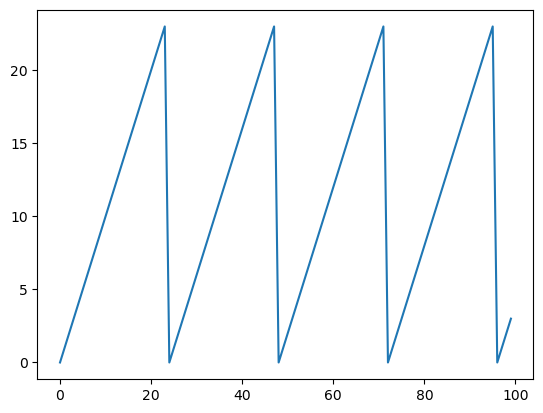

In [22]:
complete_df[:100]["hour"].plot()

In [23]:
def encode_cyclical(df, column, max_val):
    """
    Encodes a cyclical feature using sine and cosine transformations.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the column.
        column (str): The name of the cyclical column to encode.
        max_val (int): The maximum value of the cyclical feature (period).
    
    Returns:
        pd.DataFrame: DataFrame with new sine and cosine columns.
    """
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

In [24]:
# Encode 'hour' (0-23)
complete_df = encode_cyclical(complete_df, 'hour', 24)

# Encode 'day_of_week' (0-6)
complete_df = encode_cyclical(complete_df, 'day_of_week', 7)

# Encode 'month' (1-12)
complete_df = encode_cyclical(complete_df, 'month', 12)

In [25]:
# Drop original columns
#complete_df.drop(['hour', 'day_of_week', 'month'], axis=1, inplace=True)

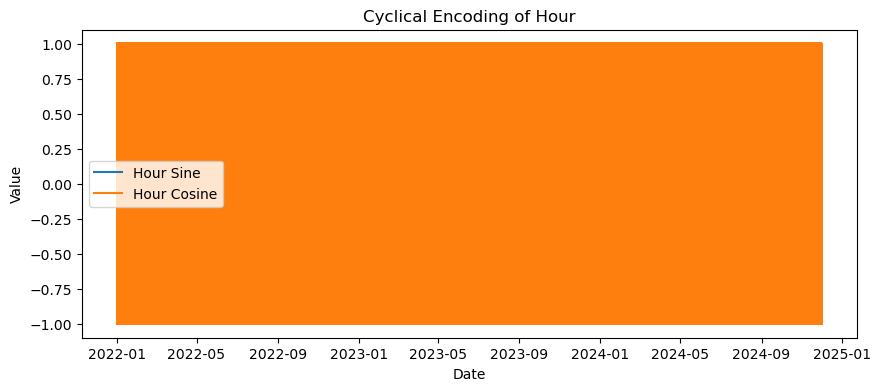

In [26]:
# Plot sine and cosine of 'hour'
plt.figure(figsize=(10, 4))
plt.plot(complete_df['effectivedate'], complete_df['hour_sin'], label='Hour Sine')
plt.plot(complete_df['effectivedate'], complete_df['hour_cos'], label='Hour Cosine')
plt.title('Cyclical Encoding of Hour')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

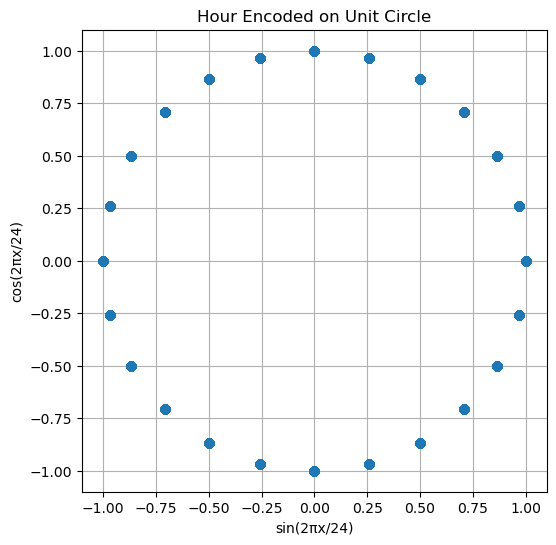

In [27]:
# Create a circular plot for 'hour'
plt.figure(figsize=(6, 6))
plt.plot(complete_df['hour_sin'], complete_df['hour_cos'], marker='o', linestyle='', alpha=0.5)
plt.title('Hour Encoded on Unit Circle')
plt.xlabel('sin(2πx/24)')
plt.ylabel('cos(2πx/24)')
plt.grid(True)
plt.show()

In [28]:
complete_df

,effectivedate,forecast_provider,plant_name,fc0,fc1200,fc40,fc55,fc60,fc75,production,...,month,day,day_of_week,hour,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2022-01-01 00:00:00,Provider 1,Plant A,5.498515,8.245363,2.456326,2.932484,2.932484,2.371797,11.886,...,1,1,5,0,0.000000,1.000000,-0.974928,-0.222521,0.5,0.866025
1,2022-01-01 01:00:00,Provider 1,Plant A,9.926987,6.013426,5.336242,3.760841,3.760841,2.797678,9.897,...,1,1,5,1,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025
2,2022-01-01 02:00:00,Provider 1,Plant A,6.701120,4.307169,9.771231,7.412186,7.412186,5.529619,7.659,...,1,1,5,2,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025
3,2022-01-01 03:00:00,Provider 1,Plant A,7.487892,3.433257,7.061040,5.776711,5.776711,5.481769,0.332,...,1,1,5,3,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025
4,2022-01-01 04:00:00,Provider 1,Plant A,0.367348,3.000605,3.415112,6.269600,6.269600,6.512737,0.251,...,1,1,5,4,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166868,2024-11-30 19:00:00,Provider 6,Plant N,9.936735,3.636002,5.631102,5.631101,5.631101,5.203560,12.280,...,11,30,5,19,-0.965926,0.258819,-0.974928,-0.222521,-0.5,0.866025
1166869,2024-11-30 20:00:00,Provider 6,Plant N,9.208887,3.967602,7.155135,6.882001,6.882001,6.585664,8.940,...,11,30,5,20,-0.866025,0.500000,-0.974928,-0.222521,-0.5,0.866025
1166870,2024-11-30 21:00:00,Provider 6,Plant N,7.232888,3.838497,6.756964,6.951433,6.951433,6.602408,11.980,...,11,30,5,21,-0.707107,0.707107,-0.974928,-0.222521,-0.5,0.866025
1166871,2024-11-30 22:00:00,Provider 6,Plant N,7.785483,4.630174,7.446291,7.334275,7.334275,7.372441,17.280,...,11,30,5,22,-0.500000,0.866025,-0.974928,-0.222521,-0.5,0.866025


In [29]:
""" # Define the number of lag periods
lag_periods = 24  # e.g., past 24 hours

# Create lag features for 'fc0' and 'production'
for lag in range(1, lag_periods + 1):
    complete_df[f'fc0_lag_{lag}'] = complete_df.groupby(['plant_name', 'forecast_provider'])['fc0'].shift(lag) """

" # Define the number of lag periods\nlag_periods = 24  # e.g., past 24 hours\n\n# Create lag features for 'fc0' and 'production'\nfor lag in range(1, lag_periods + 1):\n    complete_df[f'fc0_lag_{lag}'] = complete_df.groupby(['plant_name', 'forecast_provider'])['fc0'].shift(lag) "

In [30]:
complete_df.columns

Index(['effectivedate', 'forecast_provider', 'plant_name', 'fc0', 'fc1200',
       'fc40', 'fc55', 'fc60', 'fc75', 'production', 'capacity',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'showers', 'snowfall',
       'snow_depth', 'weather_code_x', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'et0_fao_evapotranspiration_x', 'vapour_pressure_deficit',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
       'weather_code_y', 'et0_fao_evapotranspiration_y', 'temperature_2m_max',
       'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'daylight_duration', 'sunshine_duration',
       'precipitation_sum', 'rain_sum', 'showers_sum', 'snowfall_sum',
       'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'year'

In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Define the meteorological columns
meteorological_columns = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'apparent_temperature', 'precipitation', 'rain', 'showers', 'snowfall',
    'snow_depth', 'weather_code_x', 'pressure_msl', 'surface_pressure',
    'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
    'et0_fao_evapotranspiration_x', 'vapour_pressure_deficit',
    'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
    'weather_code_y', 'et0_fao_evapotranspiration_y', 'temperature_2m_max',
    'temperature_2m_min', 'apparent_temperature_max',
    'apparent_temperature_min', 'daylight_duration', 'sunshine_duration',
    'precipitation_sum', 'rain_sum', 'showers_sum', 'snowfall_sum',
    'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max',
    'wind_direction_10m_dominant', 'shortwave_radiation_sum'
]

# Filter only the meteorological columns and the production column
df = complete_df[meteorological_columns + ['production']].dropna()

# Calculate correlations
correlations = df[meteorological_columns].corrwith(df['production'])

# Calculate mutual information
X = df[meteorological_columns]
y = df['production']
mutual_info = mutual_info_regression(X, y, random_state=42)

# Combine results into a DataFrame
results = pd.DataFrame({
    'Feature': meteorological_columns,
    'Correlation': correlations.values,
    'Mutual Information': mutual_info
}).sort_values(by='Mutual Information', ascending=False)



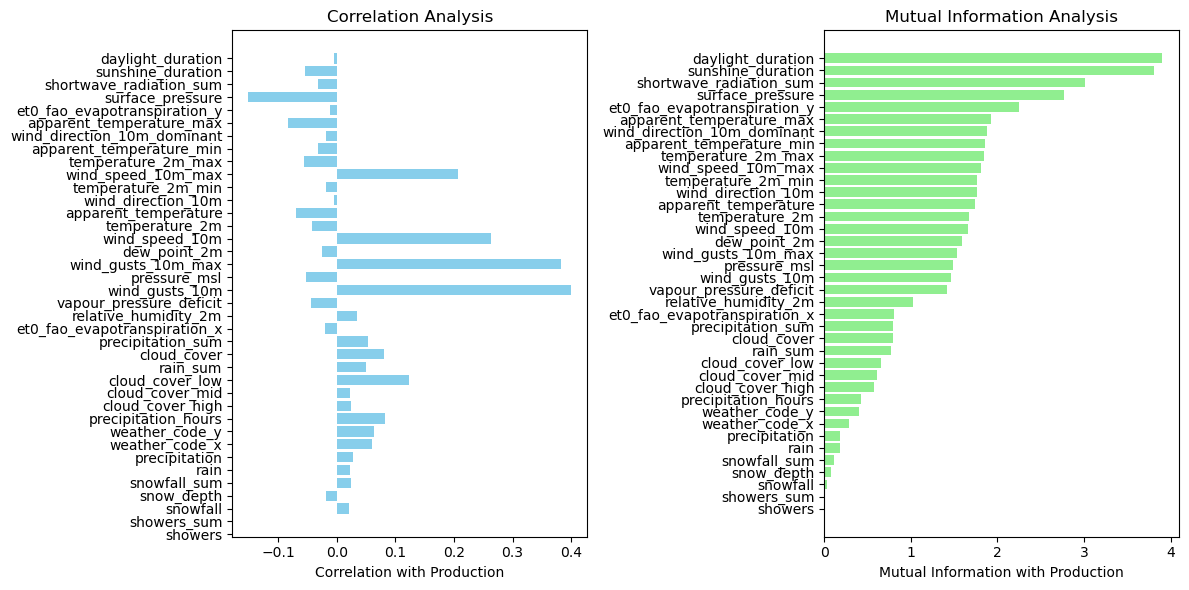

In [32]:
# Plot the results
plt.figure(figsize=(12, 6))

# Correlation plot
plt.subplot(1, 2, 1)
plt.barh(results['Feature'], results['Correlation'], color='skyblue')
plt.xlabel('Correlation with Production')
plt.title('Correlation Analysis')
plt.gca().invert_yaxis()

# Mutual Information plot
plt.subplot(1, 2, 2)
plt.barh(results['Feature'], results['Mutual Information'], color='lightgreen')
plt.xlabel('Mutual Information with Production')
plt.title('Mutual Information Analysis')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [33]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166873 entries, 0 to 1166872
Data columns (total 60 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   effectivedate                 1166873 non-null  datetime64[ns]
 1   forecast_provider             1166873 non-null  object        
 2   plant_name                    1166873 non-null  object        
 3   fc0                           1166873 non-null  float64       
 4   fc1200                        1166873 non-null  float64       
 5   fc40                          1166873 non-null  float64       
 6   fc55                          1166873 non-null  float64       
 7   fc60                          1166873 non-null  float64       
 8   fc75                          1166873 non-null  float64       
 9   production                    1166873 non-null  float64       
 10  capacity                      1166873 non-null  float64       
 11

In [34]:
complete_df

,effectivedate,forecast_provider,plant_name,fc0,fc1200,fc40,fc55,fc60,fc75,production,...,month,day,day_of_week,hour,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2022-01-01 00:00:00,Provider 1,Plant A,5.498515,8.245363,2.456326,2.932484,2.932484,2.371797,11.886,...,1,1,5,0,0.000000,1.000000,-0.974928,-0.222521,0.5,0.866025
1,2022-01-01 01:00:00,Provider 1,Plant A,9.926987,6.013426,5.336242,3.760841,3.760841,2.797678,9.897,...,1,1,5,1,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025
2,2022-01-01 02:00:00,Provider 1,Plant A,6.701120,4.307169,9.771231,7.412186,7.412186,5.529619,7.659,...,1,1,5,2,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025
3,2022-01-01 03:00:00,Provider 1,Plant A,7.487892,3.433257,7.061040,5.776711,5.776711,5.481769,0.332,...,1,1,5,3,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025
4,2022-01-01 04:00:00,Provider 1,Plant A,0.367348,3.000605,3.415112,6.269600,6.269600,6.512737,0.251,...,1,1,5,4,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166868,2024-11-30 19:00:00,Provider 6,Plant N,9.936735,3.636002,5.631102,5.631101,5.631101,5.203560,12.280,...,11,30,5,19,-0.965926,0.258819,-0.974928,-0.222521,-0.5,0.866025
1166869,2024-11-30 20:00:00,Provider 6,Plant N,9.208887,3.967602,7.155135,6.882001,6.882001,6.585664,8.940,...,11,30,5,20,-0.866025,0.500000,-0.974928,-0.222521,-0.5,0.866025
1166870,2024-11-30 21:00:00,Provider 6,Plant N,7.232888,3.838497,6.756964,6.951433,6.951433,6.602408,11.980,...,11,30,5,21,-0.707107,0.707107,-0.974928,-0.222521,-0.5,0.866025
1166871,2024-11-30 22:00:00,Provider 6,Plant N,7.785483,4.630174,7.446291,7.334275,7.334275,7.372441,17.280,...,11,30,5,22,-0.500000,0.866025,-0.974928,-0.222521,-0.5,0.866025


#### Last Preprocess (Filter & Melt & Pivot)

In [38]:
filtered_df = complete_df[(complete_df.forecast_provider=='Provider 1')|(complete_df.forecast_provider=='Provider 2')]

In [55]:
# List of columns for forecasts to reshape
forecast_columns = ['fc0', 'fc1200', 'fc40', 'fc55', 'fc60', 'fc75']

# Melt the dataframe to unpivot forecast columns
melted = filtered_df.melt(
    id_vars=[col for col in filtered_df.columns if col not in forecast_columns], 
    value_vars=forecast_columns,
    var_name='forecast_type', 
    value_name='forecast_value'
)

# Create a combined column for forecast_provider and forecast_type
melted['provider_forecast'] = (
    melted['forecast_provider'].str.replace(' ', '').str.lower() + '_' + melted['forecast_type']
)

# Pivot the table to reshape, keeping all other columns intact
reshaped = melted.pivot_table(
    index=[col for col in filtered_df.columns if col not in forecast_columns + ['forecast_provider']],
    columns='provider_forecast', 
    values='forecast_value'
).reset_index()

# Flatten the columns after pivoting
reshaped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in reshaped.columns]


# Display the reshaped dataframe
print(reshaped)

             effectivedate plant_name  production  capacity  temperature_2m  \
0      2022-01-01 00:00:00    Plant A      11.886      25.2             0.2   
1      2022-01-01 00:00:00    Plant B       7.620      23.3             2.7   
2      2022-01-01 00:00:00    Plant C       7.150      74.8             3.4   
3      2022-01-01 00:00:00    Plant D      12.940      50.5             5.3   
4      2022-01-01 00:00:00    Plant E      11.000      30.6             2.8   
...                    ...        ...         ...       ...             ...   
337901 2024-11-30 23:00:00    Plant J       0.000      29.0            -4.1   
337902 2024-11-30 23:00:00    Plant K       2.040      10.0             6.1   
337903 2024-11-30 23:00:00    Plant L       1.190       1.2             4.4   
337904 2024-11-30 23:00:00    Plant M       5.520      10.8            10.2   
337905 2024-11-30 23:00:00    Plant N      11.210      19.2            11.1   

        relative_humidity_2m  dew_point_2m  apparen

In [60]:
# List of plants to filter
plants_to_keep = ["Plant A", "Plant B", "Plant C", "Plant D", "Plant E", 
                  "Plant F", "Plant G", "Plant H", "Plant J", "Plant K"]

# Filter the dataframe
df_train = reshaped[reshaped['plant_name'].isin(plants_to_keep)]


In [64]:
df_train.to_csv("case1_training_data.csv",index=False)

Below are some additional feature-engineering ideas, beyond those already listed, that you can try to improve your wind power (MW) production forecasting model. Each suggestion includes examples or reasoning that demonstrate how the transformations could help.

---

## 1. Temporal and Lag-Based Features

### 1.1. Lagged Production Values
- **What**: Create features that represent historical production values at prior time steps (e.g., 1 hour ago, 2 hours ago, 24 hours ago).
- **Why**: Wind farms often exhibit autocorrelation—today’s production can be correlated with past production if similar conditions persist.
- **Example**:
  - `production_lag_1` = production at t-1 hour
  - `production_lag_24` = production at t-24 hours

### 1.2. Rolling/Moving Statistics of Production
- **What**: Compute rolling mean, rolling standard deviation, or rolling min/max over a window of historical production values.
- **Why**: Helps capture short-term or medium-term trends, as well as volatility in generation.
- **Example**:
  - `production_rolling_mean_6h` = average production of the past 6 hours
  - `production_rolling_std_12h` = standard deviation of the past 12 hours

### 1.3. Lagged Weather Variables
- **What**: Create lagged versions of wind speed, wind gusts, temperature, etc.
- **Why**: Wind and temperature patterns can have effects that persist or shift in time (e.g., a front passing through may shift production after a delay).
- **Example**:
  - `wind_speed_10m_lag_1` = wind speed at t-1 hour
  - `wind_speed_10m_lag_3` = wind speed at t-3 hours

---

## 2. Interaction Features

### 2.1. Wind Speed × Wind Direction
- **What**: Convert wind speed and direction to “vector” components or create an interaction term.
- **Why**: Wind direction influences how effectively the wind hits the turbines; speed alone may not capture this well.
- **Example**:
  - `wind_u` = `wind_speed_10m` * cos(`wind_direction_10m` in radians)
  - `wind_v` = `wind_speed_10m` * sin(`wind_direction_10m` in radians)

### 2.2. Gusts × Direction
- **What**: Same concept, but with gusts if they significantly impact production.
- **Why**: Occasional strong gusts from certain directions might cause disruptions or spikes.
- **Example**:
  - `wind_gust_u` = `wind_gusts_10m` * cos(`wind_direction_10m` in radians)
  - `wind_gust_v` = `wind_gusts_10m` * sin(`wind_direction_10m` in radians)

### 2.3. Wind Speed Non-Linearities
- **What**: Capture non-linear relationships. For instance, power output often behaves non-linearly as wind speed changes.
- **Why**: Turbine power curves often plateau above certain speeds and may be zero below a cut-in speed.
- **Example**:
  - `wind_speed_squared` = (`wind_speed_10m`)²
  - `wind_speed_cubed` = (`wind_speed_10m`)³

---

## 3. Advanced Time-Related Features

### 3.1. Holiday/Weekend Indicators
- **What**: Add binary flags to indicate if the date is a weekend or holiday.
- **Why**: Even though it might not directly affect wind, there could be operational differences, maintenance schedules, or data reporting quirks on weekends/holidays.
- **Example**:
  - `is_weekend` = 1 if day_of_week ∈ {Saturday, Sunday}, else 0
  - `is_holiday` = 1 if date is in a holiday list, else 0

### 3.2. Sunrise/Sunset Gaps or Shifts
- **What**: Already have `daylight_duration`, but you could derive exact sunrise or sunset times for each day and consider the difference between the current hour and sunrise/sunset.
- **Why**: Wind patterns can shift around sunrise/sunset due to temperature and atmospheric stability changes.
- **Example**:
  - `hours_since_sunrise`
  - `hours_until_sunset`

### 3.3. Trend Features Over Multiple Days
- **What**: Compute a trend or difference feature across multiple days to capture slow-moving weather patterns.
- **Why**: Large-scale weather systems that evolve over days can impact production.
- **Example**:
  - `temperature_trend_3d` = mean(temperature from past 3 days) - mean(temperature from past 4–6 days)

---

## 4. Categorical Embeddings or Encodings

### 4.1. Encoding of `plant_name`
- **What**: Convert `plant_name` from categorical to numeric embeddings (via one-hot or target encoding, or learned embeddings in a neural network).
- **Why**: Different wind parks have different turbine models, different terrain, etc. Capturing park-specific differences is crucial.
- **Example**:
  - `plant_name_encoding` could be an integer or a set of embedding dimensions learned from the data.

### 4.2. Encoding of `forecast_provider`
- **What**: Similarly, encode forecast provider as a categorical feature.
- **Why**: Different providers might have systematic biases in their wind speed/direction forecasts.
- **Example**:
  - One-hot encode or target encode each forecast provider.

---

## 5. Weather Condition Class Features

### 5.1. Simplified Weather Code Bins
- **What**: Combine complex weather codes (e.g., `weather_code_x` / `weather_code_y`) into broader categories—like “Clear,” “Rain,” “Snow,” “Storm,” etc.
- **Why**: Too many distinct weather codes can dilute the model; grouping them might find stronger correlations to production.
- **Example**:
  - `weather_category` = “Clear” if weather code in {0, 1}, “Rain” if in {2, 3, 51, 53, etc.}, “Snow” if in {71, 73, 75}, etc.

### 5.2. Binary Weather Flags
- **What**: For each major weather phenomenon (e.g., precipitation, snowfall, thunderstorm), create a 0/1 flag.
- **Why**: Some models might better interpret discrete weather events than a numeric code.
- **Example**:
  - `is_raining` = 1 if precipitation > 0, else 0
  - `is_snowing` = 1 if snowfall > 0, else 0

---

## 6. Capacity Utilization and Scaled Output

### 6.1. Production/Capacity Ratio
- **What**: The ratio of actual production to capacity might be more stable to predict than raw MW.
- **Why**: Different wind parks may have different rated capacities, and normalizing can help the model generalize.
- **Example**:
  - `production_ratio` = `production` / `capacity`

### 6.2. Weather-Power Factor
- **What**: Combine capacity with wind speed, air density (inferred from temperature & pressure), or other relevant weather variables to create a “potential power” metric.
- **Why**: Turbine power depends on air density (related to pressure and temperature) as well as wind speed.
- **Example**:
  - `air_density_approx` = `pressure_msl` / (287.05 * (temperature_2m + 273.15))  (simplified)
  - `potential_power` = `capacity` * (wind_speed_10m³) * `air_density_approx`

---

## 7. Spatial/Geographical Features

If you have coordinates or topography info for each wind park:

### 7.1. Elevation, Distance from Coast, or Terrain Type
- **What**: Add meta-information about the park location (elevation, roughness length, distance to ocean, etc.).
- **Why**: Wind patterns vary significantly based on terrain and proximity to water.
- **Example**:
  - `elevation_m`
  - `distance_to_coast_km`

### 7.2. Location Embeddings
- **What**: If you have latitude/longitude, you could cluster or embed locations to capture regional wind patterns.
- **Why**: Nearby wind farms may experience similar meteorological conditions.
- **Example**:
  - `lat_lon_clusters` = cluster label after K-means on lat-lon
  - `region_code` = group by broader region (e.g., NW, NE, SW, SE)

---

## 8. Engineering from “fc” Columns (Forecast Columns)

You mentioned `fc0`, `fc1200`, etc. These might be forecast data at different lead times:

### 8.1. Forecast Error or Bias
- **What**: If you have actual wind speed or weather data vs. forecast, create a “forecast error” feature.
- **Why**: Systematic bias in the forecast can degrade the model if it’s not accounted for.
- **Example**:
  - `wind_forecast_error` = (forecasted_wind_speed - actual_wind_speed)

### 8.2. Aggregated Forecast Statistics
- **What**: If `fc0` to `fc1200` are multiple forecasts at different hours, sum or average them to get an idea of the overall forecast trend.
- **Why**: Combining multiple future forecasts might capture a general outlook better than a single point in time.
- **Example**:
  - `forecast_mean` = average of all fc columns
  - `forecast_std` = standard deviation across those fc columns

---

## 9. Data Quality and Outlier Handling

### 9.1. Missing Data Indicators
- **What**: If weather sensors occasionally fail, create binary flags that indicate missing or imputed data.
- **Why**: The model might interpret certain missing patterns in meaningful ways (maintenance outages, sensor malfunctions).
- **Example**:
  - `wind_speed_missing` = 1 if wind speed data was missing or imputed, else 0

### 9.2. Outlier Flags
- **What**: Sometimes extreme outliers in wind speed or production might reflect anomalies. Mark them for the model.
- **Why**: The model can learn to discount them or treat them differently.
- **Example**:
  - `outlier_production` = 1 if production is above (mean + 3 std) or below (mean - 3 std)

---

## 10. Model-Specific Feature Transformations

### 10.1. Polynomial & Spline Features
- **What**: For advanced regression or tree-based models, you can create polynomial or spline transformations of important continuous features (wind speed, temperature, etc.).
- **Why**: Helps the model capture complex curves if you’re not using a flexible model (like some linear methods).
- **Example**:
  - For wind speed: 2nd, 3rd, or 4th degree polynomials
  - For temperature: piecewise transformations (splines)

### 10.2. Feature Selection / Dimensionality Reduction
- **What**: With many correlated weather features, you can try PCA or other dimensionality reduction to group correlated variables.
- **Why**: It might reduce noise and help the model generalize.
- **Example**:
  - `pca_1`, `pca_2`, etc. from all weather features

---

## Putting It All Together

When implementing new features, remember to:
1. **Check correlation** with your target (`production`) or `production_ratio` to ensure the new features are potentially helpful.  
2. **Avoid data leakage** by ensuring lag or rolling features use only past data.  
3. **Scale/normalize** features appropriately if your model is sensitive to scale.  
4. **Perform cross-validation** to confirm that new features actually improve performance rather than just adding complexity.

By systematically experimenting with the above transformations—especially leveraging lagged features, engineered wind components, and normalized production ratios—you can significantly improve your wind power forecasting model. Good luck!

#### Feature Notes

1. Provider forecasts should be separate columns.
2. Plant names should be encoded and/or train models separately for plants
3. For single model for all plants -> try to predict production/capacity

In [98]:
df_train = pd.read_csv("case1_training_data.csv")

In [99]:
df_train['production'] = df_train['production'].clip(lower=0)

In [100]:
data = df_train.copy()

#### Forecast Features

In [101]:
# Define time differences for the forecast columns (in minutes)
time_differences = {
    "fc1200": 1200,
    "fc75": 75,
    "fc60": 60,
    "fc55": 55,
    "fc40": 40,
    "fc0": 0
}

# Initialize an empty DataFrame to store new features
new_features = pd.DataFrame()

for provider in ['provider1', 'provider2']:
    # Create ramp features (difference between the latest and the oldest forecast)
    new_features[f'{provider}_ramp'] = data[f'{provider}_fc0'] - data[f'{provider}_fc1200']

    # Create speed features (rate of change between consecutive forecasts)
    for (key1, t1), (key2, t2) in zip(list(time_differences.items())[:-1], list(time_differences.items())[1:]):
        speed_feature = f'{provider}_speed_{key1}_to_{key2}'
        new_features[speed_feature] = (data[f'{provider}_{key1}'] - data[f'{provider}_{key2}']) / (t1 - t2)

    # Create volatility features (range of forecast values)
    forecast_columns = [f'{provider}_{key}' for key in time_differences.keys()]
    new_features[f'{provider}_volatility'] = data[forecast_columns].max(axis=1) - data[forecast_columns].min(axis=1)


    # Create standard deviation feature
    new_features[f'{provider}_std_fc'] = data[forecast_columns].std(axis=1)

    # Create mean forecast feature
    new_features[f'{provider}_mean_fc'] = data[forecast_columns].mean(axis=1)

# Combine new features with the original dataset
data = pd.concat([data, new_features], axis=1)


#### Time Features

In [102]:
data['effectivedate'] = pd.to_datetime(data['effectivedate'])
data['season'] = data['effectivedate'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Autumn
data['is_weekend'] = data['effectivedate'].dt.dayofweek >= 5  # Saturday and Sunday
data['time_of_day'] = pd.cut(data['effectivedate'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
data['week_of_year'] = data['effectivedate'].dt.isocalendar().week

#### Weather Codes

In [103]:
def categorize_weather(code):
    if code in {0, 1}:
        return "Clear"
    elif code in {2, 3, 51, 53, 61, 63}:
        return "Rain"
    elif code in {71, 73, 75}:
        return "Snow"
    elif code in {95, 96, 99}:
        return "Storm"
    else:
        return "Other"

data['weather_category_x'] = data['weather_code_x'].apply(categorize_weather)
data = data.drop(columns="weather_code_y")
data['weather_category_x'] = data['weather_category_x'].astype('category').cat.codes

#### Interaction

In [104]:
# Interaction Features
# 2.1 Wind Speed × Wind Direction
wind_dir_rad = np.radians(data['wind_direction_10m'])
data['wind_u'] = data['wind_speed_10m'] * np.cos(wind_dir_rad)
data['wind_v'] = data['wind_speed_10m'] * np.sin(wind_dir_rad)

# 2.2 Gusts × Direction
wind_gust_dir_rad = np.radians(data['wind_direction_10m'])
data['wind_gust_u'] = data['wind_gusts_10m'] * np.cos(wind_gust_dir_rad)
data['wind_gust_v'] = data['wind_gusts_10m'] * np.sin(wind_gust_dir_rad)

#### Non-Linearity

In [105]:
data['wind_speed_squared'] = data['wind_speed_10m'] ** 2
data['wind_speed_cubed'] = data['wind_speed_10m'] ** 3

#### Plant name encoding

In [106]:
data['plant_name'] = data['plant_name'].astype('category').cat.codes

#### Binary Flags

In [107]:
# 5.2 Binary Weather Flags
data['is_raining'] = (data['precipitation'] > 0).astype(int)
data['is_snowing'] = (data['snowfall'] > 0).astype(int)

#### Final & Save

In [119]:
data = data.dropna()

In [123]:
data.isna().sum()[-50:]

hour                              0
hour_sin                          0
hour_cos                          0
day_of_week_sin                   0
day_of_week_cos                   0
month_sin                         0
month_cos                         0
provider1_fc0                     0
provider1_fc1200                  0
provider1_fc40                    0
provider1_fc55                    0
provider1_fc60                    0
provider1_fc75                    0
provider2_fc0                     0
provider2_fc1200                  0
provider2_fc40                    0
provider2_fc55                    0
provider2_fc60                    0
provider2_fc75                    0
provider1_ramp                    0
provider1_speed_fc1200_to_fc75    0
provider1_speed_fc75_to_fc60      0
provider1_speed_fc60_to_fc55      0
provider1_speed_fc55_to_fc40      0
provider1_speed_fc40_to_fc0       0
provider1_volatility              0
provider1_std_fc                  0
provider1_mean_fc           

In [111]:
data

,effectivedate,plant_name,production,capacity,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,...,week_of_year,weather_category_x,wind_u,wind_v,wind_gust_u,wind_gust_v,wind_speed_squared,wind_speed_cubed,is_raining,is_snowing
0,2022-01-01 00:00:00,0,11.886,25.2,0.2,91.0,-1.1,-3.5,0.0,0.0,...,52,2,7.208505,6.490567,19.247451,17.330483,94.09,912.673,0,0
1,2022-01-01 00:00:00,1,7.620,23.3,2.7,74.0,-1.4,-0.7,0.0,0.0,...,52,2,0.376819,7.190133,1.355501,25.864505,51.84,373.248,0,0
2,2022-01-01 00:00:00,2,7.150,74.8,3.4,64.0,-2.7,0.6,0.0,0.0,...,52,0,-2.138416,1.089577,-7.662656,3.904318,5.76,13.824,0,0
3,2022-01-01 00:00:00,3,12.940,50.5,5.3,85.0,3.0,2.6,0.0,0.0,...,52,0,2.177535,7.593967,4.465325,15.572439,62.41,493.039,0,0
4,2022-01-01 00:00:00,4,11.000,30.6,2.8,90.0,1.2,-0.4,0.0,0.0,...,52,2,2.543634,8.319851,4.941082,16.161550,75.69,658.503,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256045,2024-11-30 23:00:00,5,0.000,57.0,-0.1,70.0,-4.9,-3.3,0.0,0.0,...,48,0,0.725766,2.910887,2.346642,9.411869,9.00,27.000,0,0
256046,2024-11-30 23:00:00,6,54.860,112.2,7.0,78.0,3.4,4.3,0.0,0.0,...,48,0,-4.802160,6.146484,-9.542753,12.214167,60.84,474.552,0,0
256047,2024-11-30 23:00:00,7,0.800,7.2,11.5,72.0,6.7,7.8,0.0,0.0,...,48,2,-16.857278,10.947245,-31.701747,20.587356,404.01,8120.601,0,0
256048,2024-11-30 23:00:00,8,0.000,29.0,-4.1,65.0,-9.7,-7.5,0.0,0.0,...,48,0,-0.927184,-0.374607,-6.026695,-2.434943,1.00,1.000,0,0


In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256050 entries, 0 to 256049
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   effectivedate                   256050 non-null  datetime64[ns]
 1   plant_name                      256050 non-null  int8          
 2   production                      256050 non-null  float64       
 3   capacity                        256050 non-null  float64       
 4   temperature_2m                  256050 non-null  float64       
 5   relative_humidity_2m            256050 non-null  float64       
 6   dew_point_2m                    256050 non-null  float64       
 7   apparent_temperature            256050 non-null  float64       
 8   precipitation                   256050 non-null  float64       
 9   rain                            256050 non-null  float64       
 10  showers                         256050 non-null  float64

In [128]:
data = data.drop(columns=["showers","showers_sum"])

In [130]:
data.to_csv("c1_train.csv",index=False)

In [132]:
data.columns

Index(['effectivedate', 'plant_name', 'production', 'capacity',
       'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code_x', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'et0_fao_evapotranspiration_x', 'vapour_pressure_deficit',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
       'et0_fao_evapotranspiration_y', 'temperature_2m_max',
       'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'daylight_duration', 'sunshine_duration',
       'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
       'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'year',
       'month', 'day', 'day_of_week', 'hour', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'mon